In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns

In [2]:
df  = pd.read_csv("car_details_from_car_dekho.csv.xls")
print('Shape: ',df.shape)
df.head()

Shape:  (4340, 8)


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [3]:
enc = LabelEncoder()

#split name into company and model
df['company'] = df['name'].apply(lambda x: x.split(' ')[0])
df['model'] = df['name'].apply(lambda x: x.split(' ')[1:])
df['model'] = df['model'].apply(lambda x: ' '.join(x))
df2 = df.drop(['name'], axis=1)

df2.head()

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,company,model
0,2007,60000,70000,Petrol,Individual,Manual,First Owner,Maruti,800 AC
1,2007,135000,50000,Petrol,Individual,Manual,First Owner,Maruti,Wagon R LXI Minor
2,2012,600000,100000,Diesel,Individual,Manual,First Owner,Hyundai,Verna 1.6 SX
3,2017,250000,46000,Petrol,Individual,Manual,First Owner,Datsun,RediGO T Option
4,2014,450000,141000,Diesel,Individual,Manual,Second Owner,Honda,Amaze VX i-DTEC


In [4]:
enc.fit(df2['company'])
df2['company'] = enc.transform(df2['company'])
enc.fit(df2['model'])
df2['model'] = enc.transform(df2['model'])
enc.fit(df2['seller_type'])
df2['seller_type'] = enc.transform(df2['seller_type'])
enc.fit(df2['owner'])
df2['owner'] = enc.transform(df2['owner'])
enc.fit(df2['fuel'])
df2['fuel'] = enc.transform(df2['fuel'])
enc.fit(df2['transmission'])
df2['transmission'] = enc.transform(df2['transmission'])

df2.head()

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,company,model
0,2007,60000,70000,4,1,1,0,18,12
1,2007,135000,50000,4,1,1,0,18,1317
2,2012,600000,100000,1,1,1,0,10,1256
3,2017,250000,46000,4,1,1,0,5,941
4,2014,450000,141000,1,1,1,2,9,106


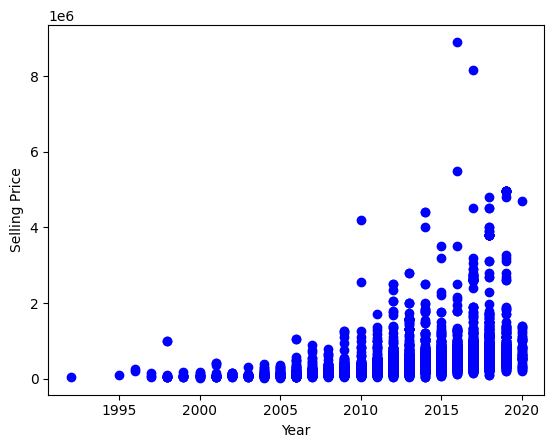

In [5]:
plt.scatter(df2.year, df2.selling_price,  color='blue')
plt.xlabel("Year")
plt.ylabel("Selling Price")
plt.show()

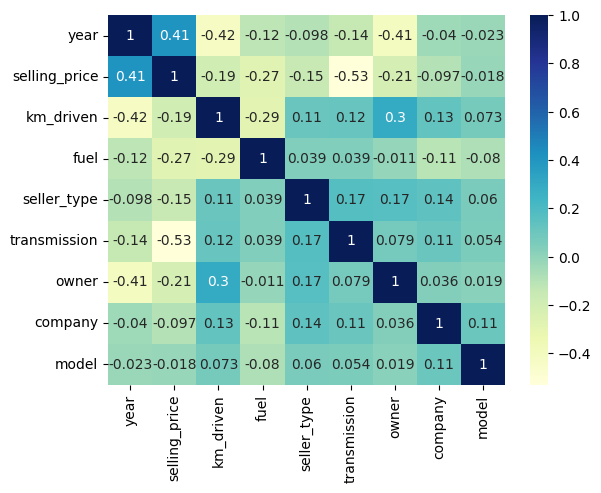

In [6]:
sns.heatmap(df2.corr(),annot = True, cmap="YlGnBu")
plt.show()

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X = np.asanyarray(df2[['year','km_driven', 'fuel', 'transmission', 'owner', 'company', 'seller_type','model']])
y = np.asanyarray(df2[['selling_price']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (3255, 8)
X_test shape:  (1085, 8)


In [8]:
params = {
    'criterion': ['friedman_mse', 'squared_error', 'absolute_error', 'poisson']
}
clf = DecisionTreeRegressor()
grid = GridSearchCV(clf, params)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

print('Feature importance: ', best_model.feature_importances_)
print('Feature with 0 importance: ', np.sum(best_model.feature_importances_ == 0))

X_train_selected = X_train[:, best_model.feature_importances_ > 0.1]
X_test_selected = X_test[:, best_model.feature_importances_ > 0.1]


print('X_train_train_selectedn shape: ', X_train_selected.shape)
print('X_test_selected shape: ', X_test_selected.shape)

Feature importance:  [0.14695689 0.1494803  0.11987323 0.27725285 0.00237973 0.12193702
 0.04430248 0.13781751]
Feature with 0 importance:  0
X_train_train_selectedn shape:  (3255, 6)
X_test_selected shape:  (1085, 6)


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

clf = LinearRegression()
y_pred = clf.fit(X_train_selected, y_train).predict(X_test_selected)

print('MSE: ', mean_squared_error(y_test, y_pred))


MSE:  142477336280.93536


In [10]:
params = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False],
}

clf = LinearRegression()
scorer = make_scorer(mean_squared_error, greater_is_better=False)
grid = GridSearchCV(clf, params, cv=5, scoring=scorer)
grid.fit(X_train_selected, y_train)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor MSE en conjunto de entrenamiento:", -grid.best_score_)  # Convertir a positivo ya que 'greater_is_better' es False

# Obtener las predicciones en el conjunto de prueba
y_pred = grid.predict(X_test_selected)

# Calcular el MSE en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_pred)
print("MSE en conjunto de prueba:", mse_test)

Mejores hiperparámetros: {'copy_X': True, 'fit_intercept': True, 'positive': False}
Mejor MSE en conjunto de entrenamiento: 199709408986.61224
MSE en conjunto de prueba: 142477336280.93536
